Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


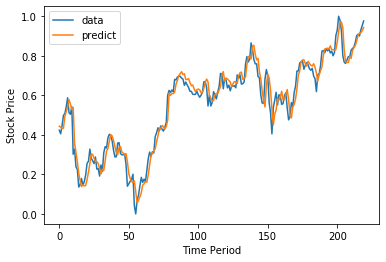

In [1]:
'''
This script shows how to predict stock prices using a basic RNN
'''
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)  # reproducibility

# if "DISPLAY" not in os.environ:
#     # remove Travis CI Error
#     matplotlib.use('Agg')

import matplotlib.pyplot as plt


def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.nn.rnn_cell.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.layers.dense(
    outputs[:, -1], output_dim)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        #print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    #print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY, label='data')
    plt.plot(test_predict, label='predict')
    plt.legend()
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()